In [1]:
import pandas as pd
from step4_model_testing.model_testing import *

path = '/Users/jeremy_gp/Documents/GitHub/SummerIndependentProject/factors_data/'
symbol = 'EHF'
data = pd.read_csv(path + '{}_factors.csv'.format(symbol), index_col=0)
data.index = pd.to_datetime(data.index)
data['delta_1'] = data['spread'].diff().shift(-1)
data = data.loc['2022-09-02':]
# lists = ['spread', 'RSI', 'MACD', 'MACDhist','EMA_5', 'MA_5']
lists = ['spread', 'RSI']
data = test_logistic(data, lists, pd.to_datetime('2022-09-02 09:05:00'), 20, 1, symbol, 'RSI',0.8, 0.2)
data

/Users/jeremy_gp/Documents/GitHub/SummerIndependentProject/step4_model_testing/model_testing.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test_preds = pd.Series()


2022-10-04 09:05:00    1
2022-10-04 09:10:00    1
2022-10-04 09:35:00    1
2022-10-04 09:40:00    1
2022-10-04 09:45:00    1
                      ..
2023-06-29 12:35:00   -1
2023-06-29 12:45:00    1
2023-06-29 12:55:00   -1
2023-06-29 13:05:00   -1
2023-06-29 13:25:00    1
Length: 3308, dtype: int64


,spread,signal,pnl
2022-09-02 09:05:00,0.001456,NaN,0
2022-09-02 09:10:00,0.000254,NaN,0
2022-09-02 09:15:00,0.001796,NaN,0
2022-09-02 09:20:00,0.001414,NaN,0
2022-09-02 09:25:00,0.002375,NaN,0
...,...,...,...
2023-06-30 13:05:00,-0.004077,NaN,0
2023-06-30 13:10:00,-0.002564,NaN,0
2023-06-30 13:15:00,-0.002856,NaN,0
2023-06-30 13:20:00,-0.002471,NaN,0


In [50]:
def valid_date_n_days_later(start, all_data, n):
    i = 1
    while i <= n:
        start = start + pd.DateOffset(days=1)
        if start in all_data.index:
            i = i + 1
        if start > all_data.index[-1]:
            return False
    return start

def valid_date_n_days_before(start, all_data, n):
    i = 1
    while i <= n:
        start = start - pd.DateOffset(days=1)
        if start in all_data.index:
            i = i + 1
        if start < all_data.index[0]:
            return False
    return start

In [51]:
start_trading_date = valid_date_n_days_later(pd.to_datetime('2022-10-03 09:05:00'), data, 20)
data['pnl'] = 0
while start_trading_date < data.index[-1]:
    end_trading_date = valid_date_n_days_later(start_trading_date, data, 1)
    if not end_trading_date:
        break
    historical_date = valid_date_n_days_before(start_trading_date, data, 20)

    historical_data = data[historical_date:start_trading_date]
    sd = np.std(historical_data['spread'], axis=0)
    mean = historical_data['spread'].mean()
    upper = mean + 1.5 * sd
    lower = mean - 1.5 * sd
    # calculate e to power of spread
    current_data = data[start_trading_date:end_trading_date]
    i = 0
    take_position = 0
    current_spread = 0
    commission_fee = 1- 0.0003

    while i < current_data.shape[0]:
        if take_position == 0:
            if current_data.iloc[i]['spread'] > upper:
                current_spread = current_data.iloc[i]['e_spread']*commission_fee
                take_position = 1
            elif current_data.iloc[i]['spread'] < lower:
                current_spread = current_data.iloc[i]['e_spread']*commission_fee
                take_position = -1
        else:
            if take_position == 1:
                if current_data.iloc[i]['spread'] < mean:
                    data.loc[current_data.index[i], 'pnl'] =  (current_spread - current_data.iloc[i]['e_spread'] )*commission_fee
                    take_position = 0
                    current_spread = 0

            if take_position == -1:
                if current_data.iloc[i]['spread'] > mean:
                    data.loc[current_data.index[i], 'pnl'] =  (current_data.iloc[i]['e_spread'] - current_spread) *commission_fee
                    take_position = 0
                    current_spread = 0

        if i == current_data.shape[0] - 1:
            if take_position == 1:
                data.loc[current_data.index[i], 'pnl'] =  (current_spread - current_data.iloc[i]['e_spread'])*commission_fee
                take_position = 0
                current_spread = 0
            if take_position == -1:
                data.loc[current_data.index[i], 'pnl'] =  (current_data.iloc[i]['e_spread'] - current_spread)*commission_fee
                take_position = 0
                current_spread = 0
        i = i + 1
    start_trading_date = end_trading_date

In [52]:
start_trading_date = valid_date_n_days_later(pd.to_datetime('2023-02-01 09:05:00'), data, 20)
data[start_trading_date:]

,spread,signal,e_spread,pnl
2023-03-03 09:05:00,0.001275,-1.0,1.001276,-0.000300
2023-03-03 09:10:00,0.000314,-1.0,1.000314,0.000000
2023-03-03 09:15:00,0.000608,-1.0,1.000608,0.000000
2023-03-03 09:20:00,-0.001409,NaN,0.998591,0.002384
2023-03-03 09:25:00,-0.000794,NaN,0.999206,0.000000
...,...,...,...,...
2023-06-30 13:05:00,-0.004077,NaN,0.995931,0.000000
2023-06-30 13:10:00,-0.002564,NaN,0.997439,0.000000
2023-06-30 13:15:00,-0.002856,NaN,0.997148,0.000000
2023-06-30 13:20:00,-0.002471,NaN,0.997532,0.000000


0.5587642135909019


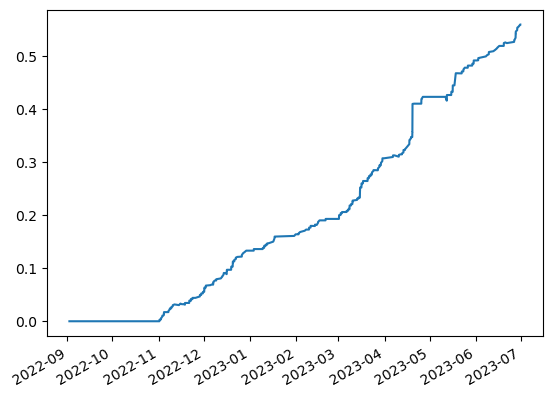

In [53]:
data['cum_pnl'] = data['pnl'].cumsum()
data['cum_pnl'].plot()
print(data['cum_pnl'].iloc[-1])

In [54]:
path = '/Users/jeremyg/Documents/GitHub/SummerIndependentProject/factors_data/'
symbol = 'EHF'
data = pd.read_csv(path + '{}_factors.csv'.format(symbol), index_col=0)
data.index = pd.to_datetime(data.index)
data['delta_1'] = data['spread'].diff().shift(-1)
data = data.loc['2022-09-02':]
# lists = ['spread', 'RSI', 'MACD', 'MACDhist','EMA_5', 'MA_5']
lists = ['spread', 'RSI']
data = test_logistic(data, lists, pd.to_datetime('2022-09-02 09:05:00'), 20, 1, symbol, 'RSI')
data['e_spread'] = np.exp(data['spread'])
data['pnl'] = 0

/Users/jeremyg/Documents/GitHub/SummerIndependentProject/step4_model_testing/model_testing.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_test_preds = pd.Series()


0.5561427874956287


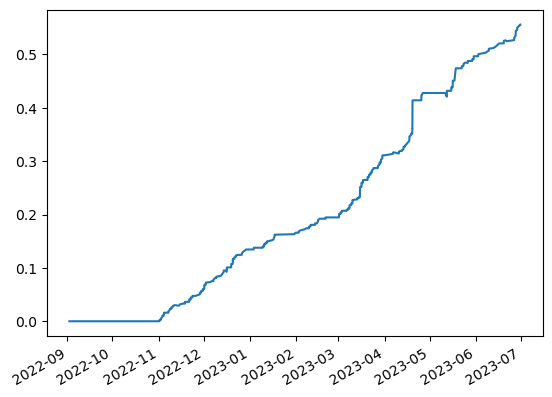

In [55]:
start_trading_date = valid_date_n_days_later(pd.to_datetime('2022-10-03 09:05:00'), data, 20)
data['pnl'] = 0
while start_trading_date < data.index[-1]:
    end_trading_date = valid_date_n_days_later(start_trading_date, data, 1)
    if not end_trading_date:
        break
    historical_date = valid_date_n_days_before(start_trading_date, data, 20)

    historical_data = data[historical_date:start_trading_date]
    sd = np.std(historical_data['spread'], axis=0)
    mean = historical_data['spread'].mean()
    upper = mean + 1.5 * sd
    lower = mean - 1.5 * sd
    # calculate e to power of spread
    current_data = data[start_trading_date:end_trading_date]
    i = 0
    take_position = 0
    current_spread = 0
    commission_fee = 1- 0.0003

    while i < current_data.shape[0]:
        if take_position == 0:
            if current_data.iloc[i]['spread'] > upper:
                if current_data.iloc[i]['signal'] != 1:
                    current_spread = current_data.iloc[i]['e_spread']
                    take_position = 1
            elif current_data.iloc[i]['spread'] < lower:
                if current_data.iloc[i]['signal'] != -1:
                    current_spread = current_data.iloc[i]['e_spread']
                    take_position = -1
        else:
            if take_position == 1:
                if current_data.iloc[i]['spread'] < mean:
                    data.loc[current_data.index[i], 'pnl'] =  (current_spread - current_data.iloc[i]['e_spread'] )*commission_fee
                    take_position = 0
                    current_spread = 0

            if take_position == -1:
                if current_data.iloc[i]['spread'] > mean:
                    data.loc[current_data.index[i], 'pnl'] =  (current_data.iloc[i]['e_spread'] - current_spread) *commission_fee
                    take_position = 0
                    current_spread = 0

        if i == current_data.shape[0] - 1:
            if take_position == 1:
                data.loc[current_data.index[i], 'pnl'] =  (current_spread - current_data.iloc[i]['e_spread'])*commission_fee
                take_position = 0
                current_spread = 0
            if take_position == -1:
                data.loc[current_data.index[i], 'pnl'] =  (current_data.iloc[i]['e_spread'] - current_spread)*commission_fee
                take_position = 0
                current_spread = 0
        i = i + 1
    start_trading_date = end_trading_date

data['cum_pnl'] = data['pnl'].cumsum()
data['cum_pnl'].plot()
print(data['cum_pnl'].iloc[-1])

In [56]:
start_trading_date = valid_date_n_days_later(pd.to_datetime('2022-10-03 09:05:00'), data, 20)
end = valid_date_n_days_later(start_trading_date, data, 1)
a = data[start_trading_date:end]
a.to_csv('test.csv')